# language classifier

## setup

In [356]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## data

In [357]:
langs = ['de', 'en', 'es', 'fr', 'it']
ltoi = {l: i for i, l in enumerate(langs)}
itol = {i: l for i, l in enumerate(langs)}

def loadtext(lang):
    with open(f'./langid/sentences.{lang}.txt', encoding='utf8') as f:
        text = f.read()
    return text

raw_texts = {lang: loadtext(lang) for lang in langs}
alphabet = set(''.join(raw_texts.values()))
stoi = {c: i for i, c in enumerate(alphabet)}
vocab_size = len(alphabet)

In [358]:
chunk_size = 1024
# ws = '\n'.join(raw_texts.values()).split('\n')
# chunk_size = len(max(ws, key=len))

def to_tokens(text):
    return torch.tensor([stoi[c] for c in text])

def chunk(text, chunk_size):
    res = []
    for t in text.split('\n'):
        t = t[:chunk_size]
        t += '\n' * (chunk_size - len(t))
        res.append(to_tokens(t))
    return res

xs = []
for land, text in raw_texts.items():
    cs = chunk(text, chunk_size)
    ls = torch.tensor([ltoi[land]] * len(cs))
    xs.extend(zip(cs, ls))
random.shuffle(xs)

train = xs[:int(len(xs) * 0.8)]
test = xs[int(len(xs) * 0.8):]

x, y = zip(*train)
x, y = torch.stack(x), torch.stack(y)

xt, yt = zip(*test)
xt, yt = torch.stack(xt), torch.stack(yt)

data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x, y),
    batch_size=128,
    shuffle=True)

data_test = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(xt, yt),
    batch_size=128,
    shuffle=True)

## by hand (character level)

In [359]:
class Toy(nn.Module):
    def __init__(self, vocab_size, max_seq_length, embedding_dim=16, hidden_dim=128):
        super().__init__()
        self.token_embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = self.create_positional_encoding(max_seq_length, embedding_dim)
        self.mlp = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, embedding_dim),
        )
        self.head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, len(langs)),
        )
        self.learned_pooling = nn.Linear(max_seq_length * embedding_dim, embedding_dim)
        self.lrn_drp_pooling = nn.Sequential(
            nn.Dropout(p=0.9),
            nn.Linear(max_seq_length * embedding_dim, embedding_dim),
        )

    def create_positional_encoding(self, max_seq_length, embedding_dim):
        position = torch.arange(max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(math.log(10000.0) / embedding_dim))
        positional_encoding = torch.zeros(max_seq_length, embedding_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding.to(device)

    def forward(self, x):
        token_embeddings = self.token_embedding(x)
        pos_token = token_embeddings + self.positional_encoding
        pos_token = self.mlp(pos_token)
        # pooling                                  # accuracy on train/test
        # =================================================================
        # pos_token = pos_token.mean(dim=1)        # 96/94
        # pos_token = pos_token.max(dim=1).values  # 99/91
        # pos_token = pos_token.sum(dim=1)         # 97/95
        pos_token = pos_token.std(dim=1)           # 99/96
        # pos_token = pos_token.min(dim=1).values  # 99/92
        # pos_token = self.learned_pooling(pos_token.view(pos_token.shape[0], -1))  # 98/88
        # pos_token = self.lrn_drp_pooling(pos_token.view(pos_token.shape[0], -1))  # 0.2@99/91 0.5@98/92 0.9@87/84

        logits = self.head(pos_token)
        return logits

In [360]:
@torch.no_grad()
def eval_loss(model, dataset):
    losses = []
    accs = []
    size = 0
    for x, y in dataset:
        size += x.shape[0]
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        losses.append(loss)
        accs.append((logits.argmax(dim=-1) == y).float().sum())
    return torch.stack(losses).mean().item(), torch.stack(accs).sum() / size

train accuracy: 0.9973763227462769
valid accuracy: 0.963018536567688


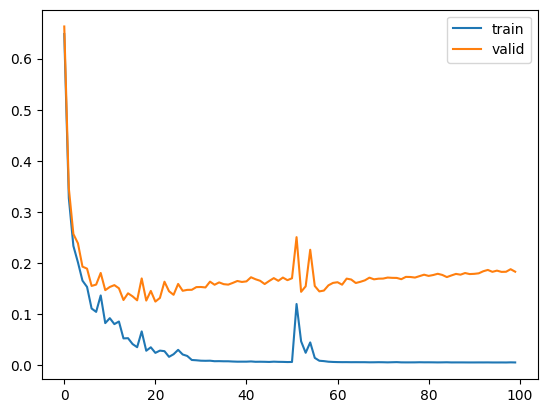

In [361]:
epochs = 100
lr = 3e-4

model = Toy(vocab_size, max_seq_length=chunk_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
losses, accs = [], []
valid_losses, valid_accs = [], []

for epoch in range(epochs):
    for x, y in data:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = F.cross_entropy(y_pred, y)
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # expensive stats
    l, a = eval_loss(model, data)
    losses.append(l)
    accs.append(a)
    l, a = eval_loss(model, data_test)
    valid_losses.append(l)
    valid_accs.append(a)

plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
print(f'train accuracy: {accs[-1]}')
print(f'valid accuracy: {valid_accs[-1]}')